# GANdy package uses demonstration
Status @ 03.15.21
***

In [1]:
import importlib

In [2]:
# imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.model_selection

import gandy.quality_est.datagen as gandy_datagen
import gandy.models.gps as gandy_gps
import gandy.models.bnns as gandy_bnns
import gandy.models.gans as gandy_gans
import gandy.optimization.hypersearch as gandy_opt

%matplotlib inline

***

In order to test our models on the ability to predict uncertainty, we synthesized test cases with known uncertainty functions. With these, we can compare the predicted uncertainties to the "true" value.

This was done foundationally as follows:

__Dataset 1__: 
- With some analytical function $f(x_1, x_2)$
- Introduce x dependant noise $g(x_1, x_2)$
- create a dataset of $y(x_1, x_2) = g + f$

__Dataset 2__:
- Repeat above but use QM9 molecular property data instead of an analytical function

## <span style="color:orange"> Loading and preparing the data</span>

In [72]:
df_analytical, noise = gandy_datagen.generate_analytical_data(to_csv=False)
df_analytical.describe()

,X1,X2,Y
count,10000.000000,10000.000000,10000.000000
mean,5.017524,4.980542,15.008350
std,2.888512,2.900130,6.564592
min,0.000476,0.001150,0.097623
25%,2.515173,2.452105,9.917427
50%,5.038690,4.929624,14.948487
75%,7.542633,7.475024,20.036410
max,9.999003,9.998874,33.653570


>The data is 2 dimensional in features and one in targets.

The full dataset with synthetic noise.

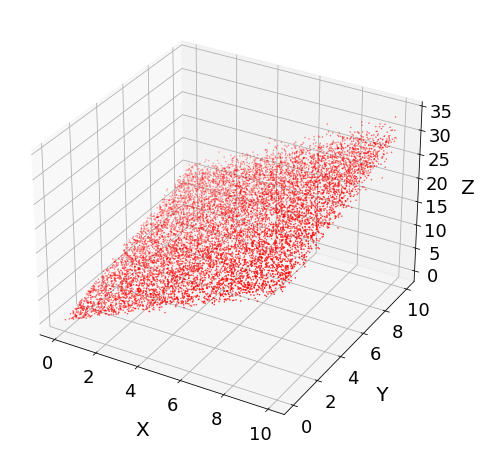

In [26]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_analytical['X1'], df_analytical['X2'], df_analytical['Y'], marker='.', color='r', s=1)

# labels
ax.set_xlabel("\n\nX", fontsize=20)
ax.set_ylabel("\n\n Y", fontsize=20)
ax.set_zlabel("   Z", fontsize=20)

# ticks
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
plt.setp(ax.get_zticklabels(), fontsize=18)

plt.show()

The analytical function - before noise addition.

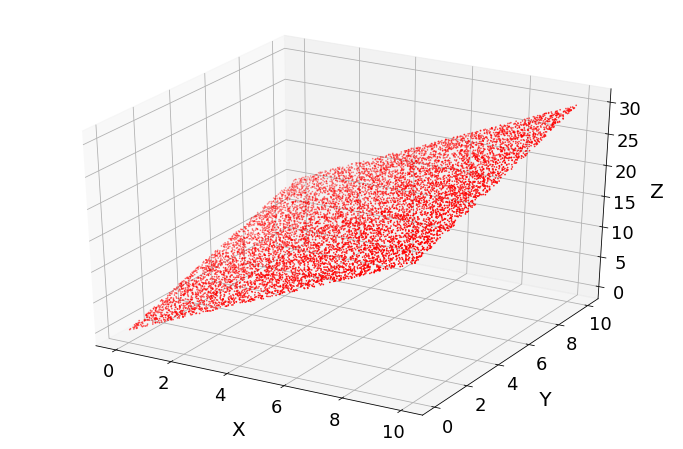

In [74]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_analytical['X1'], df_analytical['X2'], df_analytical['Y'].values - noise, marker='.', color='r', s=2)

# labels
ax.set_xlabel("\n\nX", fontsize=20)
ax.set_ylabel("\n\n Y", fontsize=20)
ax.set_zlabel("   Z", fontsize=20)

# ticks
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
plt.setp(ax.get_zticklabels(), fontsize=18)

plt.show()

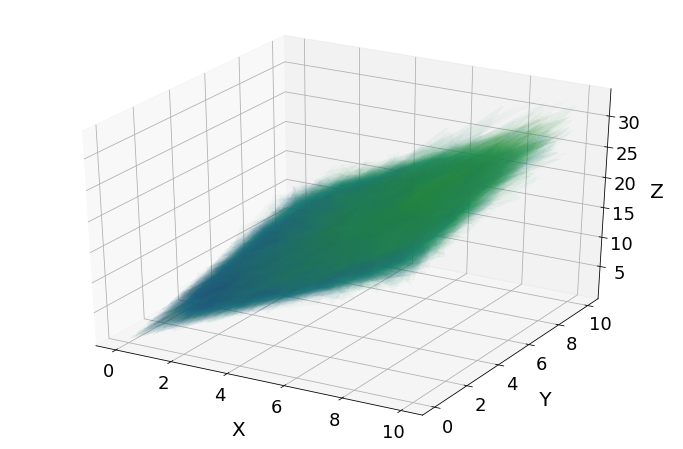

In [75]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

xx = df_analytical['X1'].values.reshape((100,100))
yy = df_analytical['X2'].values.reshape((100,100)) 
zz = df_analytical['Y'].values.reshape((100,100))

ax.plot_surface(xx, yy, zz, cmap=plt.cm.viridis, alpha=0.01,
                 linewidth = 0, antialiased=False)

# labels
ax.set_xlabel("\n\nX", fontsize=20)
ax.set_ylabel("\n\n Y", fontsize=20)
ax.set_zlabel("   Z", fontsize=20)

# ticks
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
plt.setp(ax.get_zticklabels(), fontsize=18)

plt.show()

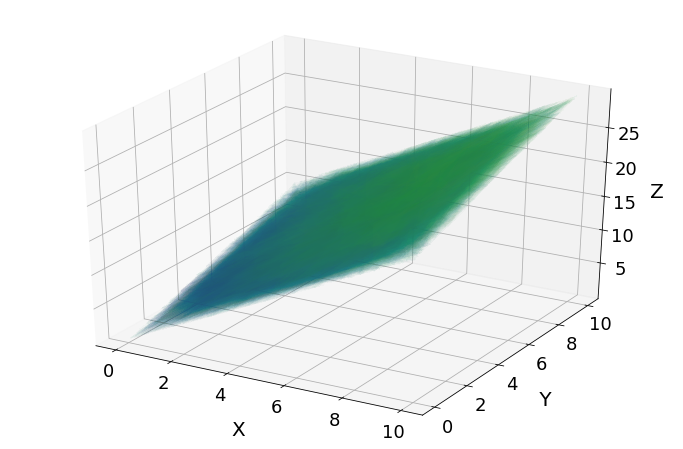

In [76]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

xx = df_analytical['X1'].values.reshape((100,100))
yy = df_analytical['X2'].values.reshape((100,100)) 
zz = df_analytical['Y'].values - noise
zz = zz.reshape((100,100))

ax.plot_surface(xx, yy, zz, cmap=plt.cm.viridis, alpha=0.01,
                 linewidth = 0, antialiased=False)

# labels
ax.set_xlabel("\n\nX", fontsize=20)
ax.set_ylabel("\n\n Y", fontsize=20)
ax.set_zlabel("   Z", fontsize=20)

# ticks
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
plt.setp(ax.get_zticklabels(), fontsize=18)

plt.show()

> The underlying analytical functions is linear, and we see an increase in noise as either X feature gets larger. We would like to reproduce this noise as uncertainty with our models.

In [5]:
## prepare the data as arrays
Xs = df_analytical[['X1', 'X2']].values
Ys = df_analytical['Y'].values.reshape(-1,1)
#. split into train and test
Xsr, Xst, Ysr, Yst = sklearn.model_selection.train_test_split(Xs, Ys, train_size=0.97)

#. scale and normalize our data
norm = sklearn.preprocessing.Normalizer()
# scale = sklearn.preprocessing.MinMaxScaler()
Xsr = norm.fit_transform(Xsr)
Xst = norm.transform(Xst)
# Ysr = scale.fit_transform(Ysr)
# Yst = scale.transform(Yst)

***

We then instatialize and train our models on these datasets. All models are built on the same class framework so follow the same procedure.

## <span style="color:orange">Gaussian processes</span>

In [6]:
# instantialize the model
gp = gandy_gps.ucGaussianProcess.R(xshape=Xsr.shape[1:],
                                   yshape=Ysr.shape[1:])

In [7]:
# train it on the training data
gp.train(Xsr, Ysr)

In [8]:
# make predictions
gp_preds, gp_uncs = gp.predict(Xst)

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\gaussian_process\gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


## <span style="color:orange"> Bayesian Neural Networks</span>

In [9]:
# instantialize the model
bnn = gandy_bnns.BNN(xshape=Xsr.shape[1:],
                     yshape=Ysr.shape[1:],
                     train_size=len(Xsr))   # we must also pass the size of the training set, necessary for BNNs to weight the divergence

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [10]:
# train it on the training data
bnn.train(Xsr, Ysr, epochs=100)

Epoch 1/100
304/304 [==============================] - ETA: 16:49 - loss: 2960.7261 - MSE: 295.762 - ETA: 1s - loss: 2440.3978 - MSE: 298.2930  - ETA: 0s - loss: 2427.1200 - MSE: 295.94 - ETA: 0s - loss: 2352.0842 - MSE: 292.61 - ETA: 0s - loss: 2279.2805 - MSE: 289.24 - ETA: 0s - loss: 2204.4210 - MSE: 286.98 - ETA: 0s - loss: 2138.7829 - MSE: 285.43 - ETA: 0s - loss: 2070.9727 - MSE: 283.97 - ETA: 0s - loss: 2005.6145 - MSE: 282.36 - ETA: 0s - loss: 1944.5029 - MSE: 280.93 - ETA: 0s - loss: 1888.0198 - MSE: 279.69 - ETA: 0s - loss: 1828.8641 - MSE: 278.47 - ETA: 0s - loss: 1777.8873 - MSE: 277.52 - ETA: 0s - loss: 1733.2262 - MSE: 276.71 - ETA: 0s - loss: 1688.0271 - MSE: 275.89 - ETA: 0s - loss: 1646.1998 - MSE: 275.10 - ETA: 0s - loss: 1611.9661 - MSE: 274.45 - ETA: 0s - loss: 1576.9025 - MSE: 273.76 - ETA: 0s - loss: 1541.2510 - MSE: 273.08 - ETA: 0s - loss: 1509.5513 - MSE: 272.48 - ETA: 0s - loss: 1477.1908 - MSE: 271.90 - 4s 4ms/step - loss: 1452.5443 - MSE: 271.4562
Epoch 2/10

In [11]:
# make predictions
bnn_preds, bnn_uncs = bnn.predict(Xst)

## <span style="color:orange"> Generative Adversarial Networks</span>

In [12]:
# instantialize the model
gan = gandy_gans.GAN(xshape=Xsr.shape[1:],
                     yshape=Ysr.shape[1:],
                     learning_rate=1e-4)

C:\Users\saman\Downloads\Anaconda\lib\site-packages\gandy\models\dcgan.py:100: UserWarning: learning_rate must start with generator_ or discriminator_
Passing learning_rate as deepchem model init kwargs.
  " model init kwargs.")


In [13]:
# train it on the training data
gan.train(Xsr, Ysr, batches=15000)

Step 1000: 	Avg gen loss 0.9207757347226143, 	Avg discrim loss 0.9885472598075866
Step 2000: 	Avg gen loss 0.8159831309914589, 	Avg discrim loss 1.4448816890716554
Step 3000: 	Avg gen loss 0.7276733231544494, 	Avg discrim loss 1.359806018948555
Step 4000: 	Avg gen loss 0.701558802485466, 	Avg discrim loss 1.3892072610855102
Step 5000: 	Avg gen loss 0.7128525974750519, 	Avg discrim loss 1.3743178702592849
Step 6000: 	Avg gen loss 0.7005957637429238, 	Avg discrim loss 1.385172275185585
Step 7000: 	Avg gen loss 0.7035723042488098, 	Avg discrim loss 1.377568622469902
Step 8000: 	Avg gen loss 0.7096520920395851, 	Avg discrim loss 1.3664797730445861
Step 9000: 	Avg gen loss 0.7129670454263687, 	Avg discrim loss 1.3627665705680847
Step 10000: 	Avg gen loss 0.7129852146506309, 	Avg discrim loss 1.3653250886201858
Step 11000: 	Avg gen loss 0.7070929239392281, 	Avg discrim loss 1.3729841356277466
Step 12000: 	Avg gen loss 0.7011884957551956, 	Avg discrim loss 1.3801872482299804
Step 13000: 	Avg 

In [14]:
# make predictions
gan_preds, gan_uncs = gan.predict(Xst)

## <span style="color:orange"> Looking back at losses</span>

All of the models store any returned losses/metrics. These can be accessed at the `sessions` attribute for every training session, and additionally if the model accepts loss types other than default it can be specified to the model.

In [15]:
gan_losses = []
for key in gan.sessions.keys():
    gan_losses.append(gan.sessions[key])
    # only get one training session losses
    break
gan_losses = np.array(gan_losses[0])
gen_loss = gan_losses[0]
dis_loss = gan_losses[1]

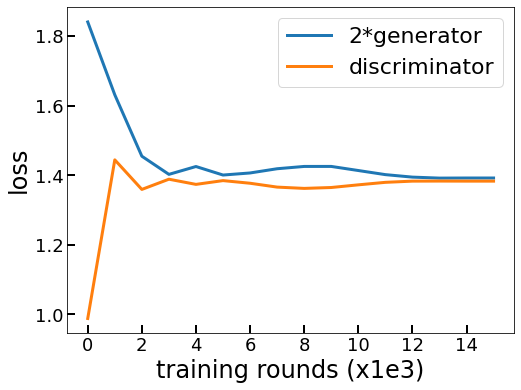

In [29]:
fig, ax = plt.subplots(figsize=(8,6))

# plotting
ax.plot(gen_loss*2, linewidth=3, label='2*generator')
ax.plot(dis_loss, linewidth=3, label='discriminator')

# labels
ax.set_ylabel('loss', size=24)
ax.set_xlabel('training rounds (x1e3)', size=24)

# format ticks
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
ax.tick_params(direction='in', width=2, length=8)

# legend
plt.legend(fontsize=22)

plt.show()

## <span style="color:orange"> Predictions</span>

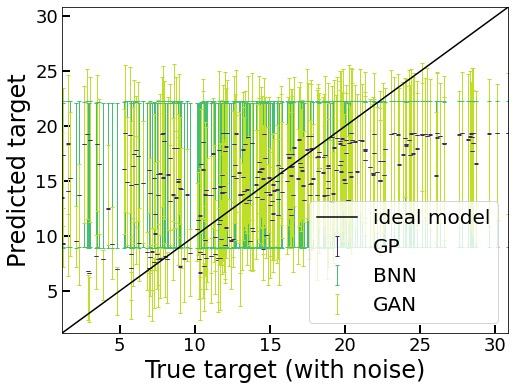

In [19]:
fig, ax = plt.subplots(figsize=(8,6))

# set ax limits
minv, maxv = Yst.min(), Yst.max()
ax.set_ylim([minv, maxv])
ax.set_xlim([minv, maxv])

Colors = plt.cm.viridis([0.1, 0.7, 0.9])

# plot predictions of models
ax.errorbar(Yst, gp_preds, yerr=gp_uncs.reshape(-1), ls='none', label='GP', linewidth=1,
            capsize=2, c=Colors[0])
ax.errorbar(Yst, bnn_preds, yerr=bnn_uncs.reshape(-1), ls='none', label='BNN', linewidth=1,
            capsize=2, c=Colors[1])
ax.errorbar(Yst, gan_preds, yerr=gan_uncs.reshape(-1), ls='none', label='GAN', linewidth=1,
            capsize=2, c=Colors[2])

# perfect result
ax.plot([minv, maxv], [minv, maxv], c='k', label='ideal model')

# labels
ax.set_ylabel('Predicted target', size=24)
ax.set_xlabel('True target (with noise)', size=24)

# format ticks
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
ax.tick_params(direction='in', width=2, length=8)

plt.legend(fontsize=20)
plt.show()

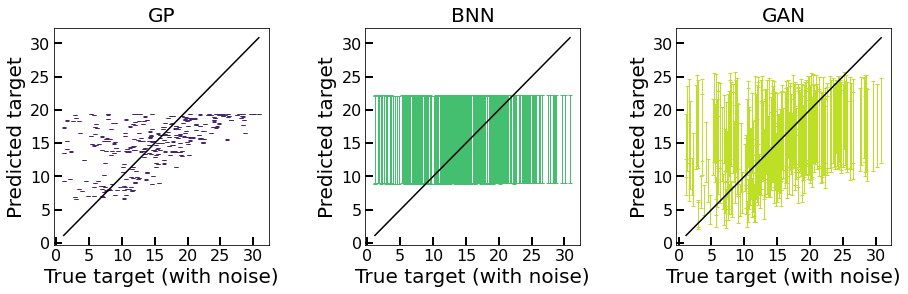

In [21]:
fig, axes = plt.subplots(figsize=(15,4), ncols=3)
fig.subplots_adjust(wspace=0.45)

# set ax limits
minv, maxv = Yst.min(), Yst.max()
ax.set_ylim([minv, maxv])
ax.set_xlim([minv, maxv])

Colors = plt.cm.viridis([0.1, 0.7, 0.9])
Preds = [gp_preds, bnn_preds, gan_preds]
Errs = [gp_uncs.reshape(-1), bnn_uncs.reshape(-1), gan_uncs.reshape(-1)]
Labels = ['GP', 'BNN', 'GAN']

# plot predictions of models
for i, ax in enumerate(axes):
    ax.errorbar(Yst, Preds[i], yerr=Errs[i], ls='none', label=Labels[i], linewidth=1,
            capsize=2, c=Colors[i])
    
    # perfect result
    ax.plot([minv, maxv], [minv, maxv], c='k', label='ideal model')
    
    # labels
    ax.set_ylabel('Predicted target', size=20)
    ax.set_xlabel('True target (with noise)', size=20)

    # format ticks
    plt.setp(ax.get_xticklabels(), fontsize=16)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    ax.tick_params(direction='in', width=2, length=8)   

    ax.set_title(f'{Labels[i]}', fontsize=20)
    
plt.show()

All of the models at a glance do pretty poorly!

__GP__: The predicted values are mostly stationary. This is fairly expected given that we have only two features and a very nonlinear function. It also is predicting 0 uncertianty for most quantities. Not good!

__BNN__: Something seems very off here, the model predicts the same quantiy and uncertainty for all values. One possible reason is that it is predicting the mean and standard deviation of the entire enemble of y values, instead of the mean and std for each y value indpependently. This is something that BNNs typically have trouble with and need to be optimized for.

__GAN__: The model seems to be on track knowing the finickyness of GANs. Optimization/more training may be required to hone in the uncertainties.

It is also apparent, especially in the GP, that the predicted target values are capped. This might be indicative of the range of the output activation function and might be solved with different scaling or normalization of the targets.

***

It might also be desireable to conduct hyperparameter search over a given model type's hyperparameters. This is achieved with the an optimization routine using [Optuna](https://github.com/optuna/optuna)'s code wrapped to fit our Uncertainty Model class.

## <span style="color:orange">Running a hyperparameter optimization</span>

Search for BNN hyperparameters - activation function and learning rate

In [77]:
# and the optimizing routine
# define the search space
search_space = {'activation': ['tanh', 'relu', 'sigmoid'],               # signifies a choice
                'optimizer_learning_rate': (0.001, 0.1, 'loguniform')}    # a continues lognormal sample space

# and the optimizing routine
opt = gandy_opt.OptRoutine(subject=gandy_bnns.BNN,
                           Xs=Xsr,
                           Ys=Ysr,
                           search_space=search_space,
                           xshape=Xsr.shape[1:],
                           yshape=Ysr.shape[1:],
                           train_size=len(Xsr),
                           metric='MSE',
                           epochs=10)

In [78]:
# run the optimization
opt.optimize(n_trials=10)

Cannot have more than one k, val_data, val_frac. Deleting k
Cannot have more than one k, val_data, val_frac.  Deleting val_data


[I 2021-03-15 16:26:50,677] A new study created in memory with name: no-name-58c651d8-1842-4362-85e1-21bb93dcc3f6


<function Trial.suggest_categorical at 0x000001D683570598>
<function Trial.suggest_loguniform at 0x000001D683570400>
{'activation': 'relu', 'optimizer_learning_rate': 0.07625426224143454}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/10
243/243 [==============================] - ETA: 11:54 - loss: 359.1161 - MSE: 366.10 - ETA: 0s - loss: nan - MSE: nan             - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - 4s 4ms/step - loss: nan - MSE: na

C:\Users\saman\Downloads\Anaconda\lib\site-packages\gandy\quality_est\metrics.py:87: UserWarning: MSE metric does not take uncertainties as arg
  warnings.warn("MSE metric does not take uncertainties as arg")
[W 2021-03-15 16:27:06,980] Trial 0 failed, because the objective function returned nan.


<function Trial.suggest_categorical at 0x000001D683570598>
<function Trial.suggest_loguniform at 0x000001D683570400>
{'activation': 'tanh', 'optimizer_learning_rate': 0.002789179615256535}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/10
243/243 [==============================] - ETA: 15:53 - loss: 469.8281 - MSE: 251.47 - ETA: 1s - loss: 919.8756 - MSE: 274.7860   - ETA: 1s - loss: 915.7663 - MSE: 276.210 - ETA: 1s - loss: 892.4927 - MSE: 277.083 - ETA: 1s - loss: 833.6265 - MSE: 276.676 - ETA: 1s - loss: 790.5742 - MSE: 275.813 - ETA: 1s - loss: 758.4355 - MSE: 275.045 - ETA: 0s - loss: 755.6896 - MSE: 274.255 - ETA: 0s - loss: 752.9588 - MSE: 273.454 - ETA: 0s - loss: 766.1071 - MSE: 272.642 - ETA: 0s - loss: 778.0120 - MSE: 272.168 - ETA: 0s - loss: 780.2744 - MSE: 272.068 - ETA: 0s - loss: 779.5158 - MSE: 271.987 - ETA: 0s - loss: 777.6760 - MSE: 271.914 - ETA: 0s - loss: 773.8815 - MSE: 271.827 - ETA: 0s - loss: 768.4393 - MSE

[I 2021-03-15 16:27:27,002] Trial 1 finished with value: 225.74160218975342 and parameters: {'activation': 'tanh', 'optimizer_learning_rate': 0.002789179615256535}. Best is trial 1 with value: 225.74160218975342.


<function Trial.suggest_categorical at 0x000001D683570598>
<function Trial.suggest_loguniform at 0x000001D683570400>
{'activation': 'sigmoid', 'optimizer_learning_rate': 0.0018764672458435941}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/10
243/243 [==============================] - ETA: 17:27 - loss: 70.6389 - MSE: 315.905 - ETA: 0s - loss: 68.7219 - MSE: 319.2377  - ETA: 0s - loss: 67.6208 - MSE: 318.21 - ETA: 0s - loss: 66.7405 - MSE: 314.42 - ETA: 0s - loss: 65.5617 - MSE: 312.83 - ETA: 0s - loss: 63.4202 - MSE: 311.72 - ETA: 0s - loss: 61.6748 - MSE: 311.19 - ETA: 0s - loss: 59.9875 - MSE: 310.88 - ETA: 0s - loss: 58.1687 - MSE: 310.16 - ETA: 0s - loss: 56.5274 - MSE: 309.55 - ETA: 0s - loss: 54.9826 - MSE: 308.94 - ETA: 0s - loss: 53.5283 - MSE: 308.27 - ETA: 0s - loss: 52.2041 - MSE: 307.55 - ETA: 0s - loss: 51.0624 - MSE: 306.81 - ETA: 0s - loss: 49.8991 - MSE: 305.96 - ETA: 0s - loss: 48.8083 - MSE: 305.16 - ETA: 0s - loss

[I 2021-03-15 16:27:46,692] Trial 2 finished with value: 54.718202325346354 and parameters: {'activation': 'sigmoid', 'optimizer_learning_rate': 0.0018764672458435941}. Best is trial 2 with value: 54.718202325346354.


<function Trial.suggest_categorical at 0x000001D683570598>
<function Trial.suggest_loguniform at 0x000001D683570400>
{'activation': 'relu', 'optimizer_learning_rate': 0.08432479186109354}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/10
243/243 [==============================] - ETA: 14:43 - loss: 302044.7812 - MSE: 292.937 - ETA: 0s - loss: nan - MSE: nan                - ETA: 1s - loss: nan - MSE: na - ETA: 1s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE:

[W 2021-03-15 16:28:05,527] Trial 3 failed, because the objective function returned nan.


<function Trial.suggest_categorical at 0x000001D683570598>
<function Trial.suggest_loguniform at 0x000001D683570400>
{'activation': 'tanh', 'optimizer_learning_rate': 0.006418814573366733}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/10
243/243 [==============================] - ETA: 16:44 - loss: 123.6374 - MSE: 310.22 - ETA: 1s - loss: 3101.1172 - MSE: 252.0950 - ETA: 1s - loss: 2675.3954 - MSE: 254.60 - ETA: 1s - loss: 2591.1782 - MSE: 258.82 - ETA: 1s - loss: 2615.6410 - MSE: 261.93 - ETA: 0s - loss: 2552.2107 - MSE: 264.40 - ETA: 0s - loss: 2449.5724 - MSE: 266.57 - ETA: 0s - loss: 2395.3747 - MSE: 267.56 - ETA: 0s - loss: 2372.6664 - MSE: 268.49 - ETA: 0s - loss: 2325.2335 - MSE: 269.24 - ETA: 0s - loss: 2274.4857 - MSE: 269.77 - ETA: 0s - loss: 2227.9843 - MSE: 270.05 - ETA: 0s - loss: 2185.1375 - MSE: 270.23 - ETA: 0s - loss: 2138.2430 - MSE: 270.38 - ETA: 0s - loss: 2084.4205 - MSE: 270.41 - ETA: 0s - loss: 2028.7078 - MSE

[I 2021-03-15 16:28:23,718] Trial 4 finished with value: 261.5642472931986 and parameters: {'activation': 'tanh', 'optimizer_learning_rate': 0.006418814573366733}. Best is trial 2 with value: 54.718202325346354.


<function Trial.suggest_categorical at 0x000001D683570598>
<function Trial.suggest_loguniform at 0x000001D683570400>
{'activation': 'relu', 'optimizer_learning_rate': 0.09626448320463721}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/10
243/243 [==============================] - ETA: 17:09 - loss: 76.0285 - MSE: 273.021 - ETA: 1s - loss: nan - MSE: nan            - ETA: 1s - loss: nan - MSE: na - ETA: 1s - loss: nan - MSE: na - ETA: 1s - loss: nan - MSE: na - ETA: 1s - loss: nan - MSE: na - ETA: 1s - loss: nan - MSE: na - ETA: 1s - loss: nan - MSE: na - ETA: 1s - loss: nan - MSE: na - ETA: 1s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ET

[W 2021-03-15 16:28:43,514] Trial 5 failed, because the objective function returned nan.


<function Trial.suggest_categorical at 0x000001D683570598>
<function Trial.suggest_loguniform at 0x000001D683570400>
{'activation': 'relu', 'optimizer_learning_rate': 0.017436635977194505}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/10
243/243 [==============================] - ETA: 14:56 - loss: 504.0811 - MSE: 300.25 - ETA: 0s - loss: 227241.6005 - MSE: 344.48 - ETA: 0s - loss: 2553025976.0865 - MSE: 437.71 - ETA: 0s - loss: 5140002517.1322 - MSE: 744.58 - ETA: 0s - loss: 5772703744.6374 - MSE: 1017.530 - ETA: 0s - loss: nan - MSE: nan                  - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na - ETA: 0s - loss: nan - MSE: na

[W 2021-03-15 16:28:59,650] Trial 6 failed, because the objective function returned nan.


<function Trial.suggest_categorical at 0x000001D683570598>
<function Trial.suggest_loguniform at 0x000001D683570400>
{'activation': 'tanh', 'optimizer_learning_rate': 0.0013631124697085094}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/10
243/243 [==============================] - ETA: 14:17 - loss: 147.6406 - MSE: 421.32 - ETA: 0s - loss: 394.3210 - MSE: 295.2996   - ETA: 0s - loss: 470.5265 - MSE: 285.197 - ETA: 0s - loss: 513.3146 - MSE: 282.367 - ETA: 0s - loss: 564.5024 - MSE: 280.572 - ETA: 0s - loss: 623.5238 - MSE: 278.818 - ETA: 0s - loss: 670.4765 - MSE: 277.676 - ETA: 0s - loss: 705.6632 - MSE: 276.740 - ETA: 0s - loss: 730.9478 - MSE: 275.870 - ETA: 0s - loss: 748.0634 - MSE: 275.255 - ETA: 0s - loss: 761.1638 - MSE: 274.786 - ETA: 0s - loss: 766.5708 - MSE: 274.335 - ETA: 0s - loss: 768.9689 - MSE: 273.914 - ETA: 0s - loss: 769.5888 - MSE: 273.595 - ETA: 0s - loss: 768.7327 - MSE: 273.360 - ETA: 0s - loss: 767.0200 - MS

[I 2021-03-15 16:29:16,165] Trial 7 finished with value: 232.10969158673146 and parameters: {'activation': 'tanh', 'optimizer_learning_rate': 0.0013631124697085094}. Best is trial 2 with value: 54.718202325346354.


<function Trial.suggest_categorical at 0x000001D683570598>
<function Trial.suggest_loguniform at 0x000001D683570400>
{'activation': 'sigmoid', 'optimizer_learning_rate': 0.0025923076228750743}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/10
243/243 [==============================] - ETA: 14:42 - loss: 964.0397 - MSE: 231.44 - ETA: 1s - loss: 1183.9052 - MSE: 265.3803 - ETA: 2s - loss: 1152.8327 - MSE: 267.22 - ETA: 1s - loss: 1127.9121 - MSE: 266.51 - ETA: 1s - loss: 1095.0319 - MSE: 265.41 - ETA: 1s - loss: 1058.8284 - MSE: 264.94 - ETA: 1s - loss: 1022.7379 - MSE: 263.98 - ETA: 1s - loss: 975.7656 - MSE: 262.4168 - ETA: 1s - loss: 926.3065 - MSE: 261.406 - ETA: 1s - loss: 889.5083 - MSE: 260.483 - ETA: 0s - loss: 851.7885 - MSE: 259.519 - ETA: 0s - loss: 810.3187 - MSE: 258.520 - ETA: 0s - loss: 776.3438 - MSE: 257.650 - ETA: 0s - loss: 745.7220 - MSE: 256.828 - ETA: 0s - loss: 717.7951 - MSE: 256.051 - ETA: 0s - loss: 701.3073 -

[I 2021-03-15 16:29:34,256] Trial 8 finished with value: 105.3447664962131 and parameters: {'activation': 'sigmoid', 'optimizer_learning_rate': 0.0025923076228750743}. Best is trial 2 with value: 54.718202325346354.


<function Trial.suggest_categorical at 0x000001D683570598>
<function Trial.suggest_loguniform at 0x000001D683570400>
{'activation': 'sigmoid', 'optimizer_learning_rate': 0.003823045670607748}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/10
243/243 [==============================] - ETA: 16:53 - loss: 425.7665 - MSE: 272.49 - ETA: 1s - loss: 449.9865 - MSE: 257.4016   - ETA: 1s - loss: 441.3053 - MSE: 258.961 - ETA: 1s - loss: 396.5759 - MSE: 257.481 - ETA: 0s - loss: 359.3004 - MSE: 255.299 - ETA: 0s - loss: 328.0299 - MSE: 253.896 - ETA: 0s - loss: 305.3387 - MSE: 252.416 - ETA: 0s - loss: 286.2829 - MSE: 250.816 - ETA: 0s - loss: 271.1835 - MSE: 249.369 - ETA: 0s - loss: 261.2204 - MSE: 248.333 - ETA: 0s - loss: 252.2432 - MSE: 247.416 - ETA: 0s - loss: 245.0063 - MSE: 246.678 - ETA: 0s - loss: 237.4610 - MSE: 245.902 - ETA: 0s - loss: 230.4745 - MSE: 245.094 - ETA: 0s - loss: 223.2966 - MSE: 244.176 - ETA: 0s - loss: 216.0204 - 

[I 2021-03-15 16:29:52,527] Trial 9 finished with value: 50.50103492189867 and parameters: {'activation': 'sigmoid', 'optimizer_learning_rate': 0.003823045670607748}. Best is trial 9 with value: 50.50103492189867.


50.50103492189867

In [79]:
# what were the best parameters?
opt.best_params

{'activation': 'sigmoid', 'optimizer_learning_rate': 0.003823045670607748}

In [80]:
# train the best model
best_bnn = opt.train_best()

metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/10
304/304 [==============================] - ETA: 19:17 - loss: 1504.5381 - MSE: 248.390 - ETA: 1s - loss: 2309.4283 - MSE: 293.7498  - ETA: 1s - loss: 1998.8890 - MSE: 294.94 - ETA: 1s - loss: 1754.2905 - MSE: 294.06 - ETA: 1s - loss: 1605.4678 - MSE: 293.74 - ETA: 0s - loss: 1483.6996 - MSE: 293.13 - ETA: 0s - loss: 1375.4663 - MSE: 292.44 - ETA: 0s - loss: 1287.2393 - MSE: 291.65 - ETA: 0s - loss: 1213.0162 - MSE: 290.69 - ETA: 0s - loss: 1154.3267 - MSE: 289.97 - ETA: 0s - loss: 1098.0716 - MSE: 289.31 - ETA: 0s - loss: 1051.9426 - MSE: 288.64 - ETA: 0s - loss: 1004.4171 - MSE: 287.83 - ETA: 0s - loss: 965.0876 - MSE: 287.1174 - ETA: 0s - loss: 929.4538 - MSE: 286.398 - ETA: 0s - loss: 899.3728 - MSE: 285.729 - ETA: 0s - loss: 873.8500 - MSE: 285.083 - ETA: 0s - loss: 856.3749 - MSE: 284.642 - ETA: 0s - loss: 839.7389 - MSE: 284.231 - ETA: 0s - loss: 821.9439 - MSE: 283.768 - ETA: 0

`best_bnn` is the BNN model with the best parameters found from the search.

***

Finally, we want to evaluate our model on its ability to predict uncertainty, such that future predictions of uncertainty are trusted. The UCP metric tests whether the uncertainty captures the true value.

## <span style="color:orange">Using an uncertainty metric</span>

In [24]:
UCP_gp, _ = gp.score(Xst, Yst, metric='UCP')
UCP_bnn, _ = bnn.score(Xst, Yst, metric='UCP')
UCP_gan, _ = gan.score(Xst, Yst, metric='UCP')

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\gaussian_process\gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [25]:
print('GP score: ', UCP_gp)
print('BNN score: ', UCP_bnn)
print('GAN score: ', UCP_gan)

GP score:  0.0
BNN score:  0.6266666666666667
GAN score:  0.6433333333333334


The GAN seems to be performing the best, barely, but none of the models are predicting very well, and need to be optimized. 

## <span style="color:orange">Determining if the data is learnable</span>

In [120]:
from sklearn import svm
import gandy.quality_est.metrics as metrics

SVR = svm.SVR()
SVR.fit(Xsr, Ysr)
svm_preds = SVR.predict(Xst)
print(SVR.score(Xst, Yst))

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.23880971614797353


In [121]:
# SVM
MSE = metrics.MSE(svm_preds, Yst)
svm_metric = MSE.calculate()[0]
print(f"SVM MSE: {svm_metric}")

SVM MSE: 59.07772797911398


In [122]:
# GP
MSE = metrics.MSE(gp_preds, Yst)
gp_metric = MSE.calculate()[0]
print(f"GP MSE: {gp_metric}")

GP MSE: 33.19774563253086


In [123]:
# BNN
MSE = metrics.MSE(bnn_preds, Yst)
bnn_metric = MSE.calculate()[0]
print(f"BNN MSE: {bnn_metric}")

BNN MSE: 46.10450089016276


In [124]:
# GAN
MSE = metrics.MSE(gan_preds, Yst)
gan_metric = MSE.calculate()[0]
print(f"GAN MSE: {gan_metric}")

GAN MSE: 34.88702198392531


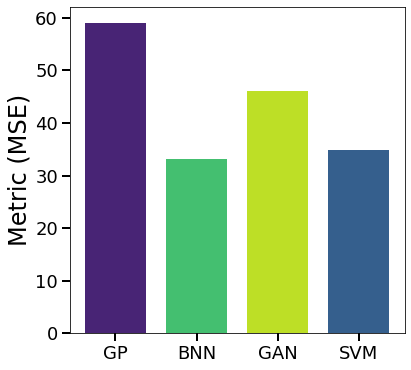

In [125]:
fig, ax = plt.subplots(figsize=(6,6))

Colors = plt.cm.viridis([0.1, 0.7, 0.9, 0.3])
MSEs = [svm_metric, gp_metric, bnn_metric, gan_metric]
x = ['GP', 'BNN', 'GAN', 'SVM']
x_pos = np.array([i for i, _ in enumerate(x)])

for i in range(4):
    width=0.75
    ax.bar(x_pos[i], MSEs[i], width=width, color=Colors[i])

    plt.xticks(x_pos, x, fontsize=24)    
    
# labels
ax.set_ylabel('Metric (MSE)', size=24)

# format ticks
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
ax.tick_params(direction='out', width=2, length=8)

plt.show()